In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.archs.transformer_layers import TFModel
from models.archs.VFIformer_arch import *
class ContinuousEventTransformer(nn.Module):
    def __init__(self, args):
        super(ContinuousEventTransformer, self).__init__()
        self.phase = args.phase
        c = 24
        height = args.crop_size
        width = args.crop_size
        window_size = 8
        embed_dim = 160

        # Flow estimation for motion context
        self.flownet = IFNet()
        self.refinenet = FlowRefineNet_Multis(c=c, n_iters=1)

        # Feature extraction block
        self.feature_block = nn.Sequential(
            nn.Conv2d(13, 2*c, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(2*c, 2*c, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        # Event representation generator
        self.event_transformer = TFModel(
            img_size=(height, width), 
            in_chans=2*c,     # Input feature channels
            out_chans=2,      # Two channels for event representation
            fuse_c=c,
            window_size=window_size, 
            img_range=1.,
            depths=[[3, 3], [3, 3], [3, 3], [1, 1]],
            embed_dim=embed_dim, 
            num_heads=[[2, 2], [2, 2], [2, 2], [2, 2]], 
            mlp_ratio=2,
            resi_connection='1conv',
            use_crossattn=[[[False, False, False, False], [True, True, True, True]], \
                   [[False, False, False, False], [True, True, True, True]], \
                   [[False, False, False, False], [True, True, True, True]], \
                   [[False, False, False, False], [False, False, False, False]]]
        )

        # Final intensity mapping to 0-255 range
        self.intensity_head = nn.Sequential(
            nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 2, kernel_size=3, stride=1, padding=1)
        )

    def compute_intensity_changes(self, img0, img1):
        """
        Compute pixel-wise intensity changes between two images
        Returns a tensor highlighting intensity variations
        """
        # Convert to grayscale and compute difference
        gray0 = torch.mean(img0, dim=1, keepdim=True)
        gray1 = torch.mean(img1, dim=1, keepdim=True)
        
        # Compute signed difference to capture direction of change
        diff = gray1 - gray0
        
        return diff

    def forward(self, img0, img1):
        B, _, H, W = img0.size()
        imgs = torch.cat((img0, img1), 1)

        # Flow estimation 
        flow, _ = self.flownet(imgs)
        flow, c0, c1 = self.refinenet(img0, img1, flow)

        # Warp images using flow
        warped_img0 = warp(img0, flow[:, :2])
        warped_img1 = warp(img1, flow[:, 2:])
        
        # Compute intensity changes
        intensity_changes = self.compute_intensity_changes(img0, img1)
        
        # Prepare feature input
        x = self.feature_block(torch.cat([img0, img1, warped_img0, warped_img1, intensity_changes], dim=1))

        # Transform features into event representation
        event_repr = self.event_transformer(x, c0, c1)
        
        # Map to final intensity representation
        event_intensity = self.intensity_head(event_repr)
        
        # Scale to 0-255 range
        event_intensity = torch.clamp(event_intensity * 255, min=0, max=255)

        return event_intensity


Event Representation Shape: torch.Size([1, 2, 192, 192])


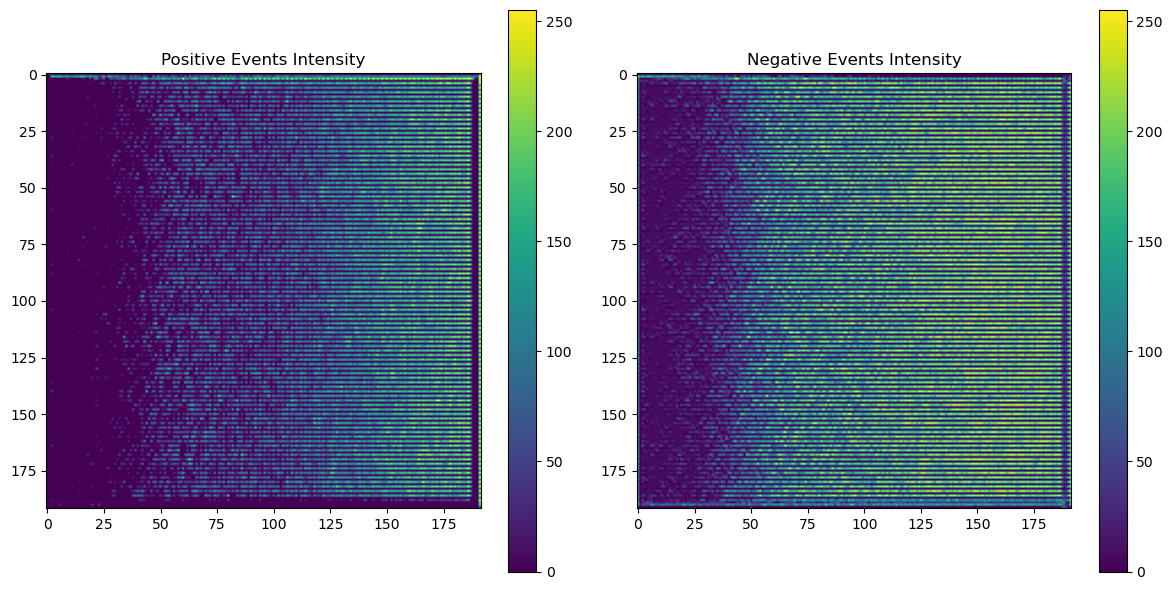

In [3]:
import torch
import matplotlib.pyplot as plt

class Args:
    def __init__(self, crop_size=192, phase='test'):
        self.crop_size = crop_size
        self.phase = phase

def create_sample_images(size=192):
    """
    Generate two sample images to simulate input frames.
    In a real scenario, these would be actual video frames.
    """
    # Create two slightly different images
    torch.manual_seed(42)
    
    # First image: Gradient background
    img0 = torch.zeros(1, 3, size, size)
    for c in range(3):
        img0[0, c] = torch.linspace(0, 1, size).view(1, -1).repeat(size, 1)
    
    # Second image: Same gradient with slight movement/change
    img1 = torch.zeros(1, 3, size, size)
    for c in range(3):
        img1[0, c] = torch.linspace(0, 1, size).view(1, -1).repeat(size, 1)
    
    # Add some noise to simulate motion/change
    img1 += torch.randn_like(img1) * 0.1
    
    return img0, img1

def visualize_event_representation(event_rep):
    """
    Visualize the two channels of the event representation
    """
    plt.figure(figsize=(12, 6))
    
    # Positive events channel
    plt.subplot(1, 2, 1)
    plt.title("Positive Events Intensity")
    plt.imshow(event_rep[0, 0].detach().cpu().numpy(), cmap='viridis')
    plt.colorbar()
    
    # Negative events channel
    plt.subplot(1, 2, 2)
    plt.title("Negative Events Intensity")
    plt.imshow(event_rep[0, 1].detach().cpu().numpy(), cmap='viridis')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

def run_event_transformer_demo():
    # Create arguments
    args = Args()

    # Select device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the model
    model = ContinuousEventTransformer(args).to(device)

    # Create sample input images
    img0, img1 = create_sample_images()
    
    # Move images to the same device as the model
    img0 = img0.to(device)
    img1 = img1.to(device)

    # Generate event representation
    with torch.no_grad():
        event_rep = model(img0, img1)

    # Print basic information about the output
    print("Event Representation Shape:", event_rep.shape)
    #print("Min Values:", event_rep.min(dim=(2,3)))
    #print("Max Values:", event_rep.max(dim=(2,3)))

    # Visualize the event representation
    visualize_event_representation(event_rep)

    return event_rep

# Run the demo
event_representation = run_event_transformer_demo()
